# Vehicle Detection
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You can submit your writeup in markdown or use another method and submit a pdf instead.

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

**As an optional challenge** Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

**If you're feeling ambitious** (also totally optional though), don't stop there!  We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!


# Solution

## Classifer

In [1]:
import numpy as np

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# print("tensorflow version", tf.__version__)

#### Import Data

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'training_data'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
#
if not isdir(dataset_folder_path):
    os.mkdir(dataset_folder_path)
        
# vehicles data
if not isfile(dataset_folder_path + '/vehicles.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Vehicle Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip',
            dataset_folder_path + '/vehicles.zip',
            pbar.hook)

if not isdir(dataset_folder_path + '/vehicles'):
    with zipfile.ZipFile(dataset_folder_path + '/vehicles.zip') as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        zip_ref.close()

# non-vehicles data
if not isfile(dataset_folder_path + '/non-vehicles.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Non-Vehicle Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip',
            dataset_folder_path + '/non-vehicles.zip',
            pbar.hook)

if not isdir(dataset_folder_path + '/non-vehicles'):
    with zipfile.ZipFile(dataset_folder_path + '/non-vehicles.zip') as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        zip_ref.close()

In [2]:
import glob

cars = glob.glob('training_data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('training_data/non-vehicles/**/*.png', recursive=True)

nb_cars = len(cars)
nb_notcars = len(notcars)

Number of vehicles 8792
Number of non-vehicles 8968


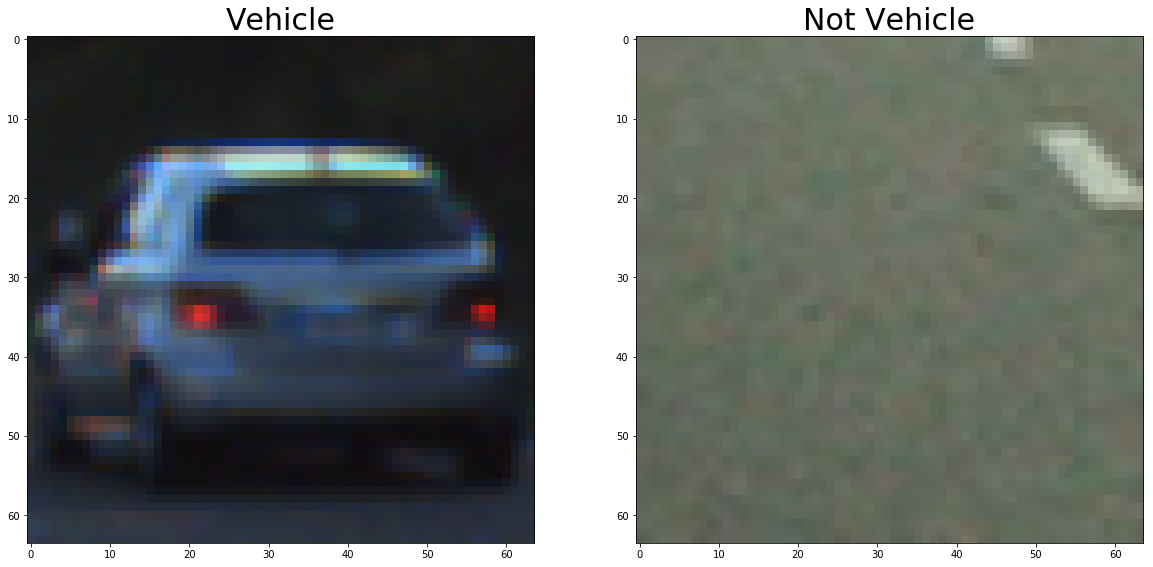

In [3]:
print("Number of vehicles", nb_cars)
print("Number of non-vehicles", nb_notcars)

idx1 = np.random.randint(nb_cars)
idx2 = np.random.randint(nb_notcars)
img1 = cv2.imread(cars[idx1])
img2 = cv2.imread(notcars[idx2])

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title('Vehicle', fontsize=30)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title('Not Vehicle', fontsize=30)

In [4]:
# Generate features
images = cars + notcars

# Generate classes
labels = np.vstack((np.ones((nb_cars, 1), dtype=np.int8),
                   np.zeros((nb_notcars, 1), dtype=np.int8)))

#### Train a classifer
Helper functions

In [5]:
from skimage.feature import hog

def bin_spatial(img, size=(32, 32)):
    """ Compute binned color features   """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    """ Compute color histogram features """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """ Create HOG features """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """ Extract features from a list of images """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Data prep

In [15]:
from sklearn.preprocessing import StandardScaler

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(scaled_X, y))
half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = scaled_X[train_idx], y[train_idx]
val_x, val_y = scaled_X[val_idx], y[val_idx]
test_x, test_y = scaled_X[test_idx], y[test_idx]

In [17]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (14208, 2580) (14208,)
Validation shapes (x, y): (1776, 2580) (1776,)
Test shapes (x, y): (1776, 2580) (1776,)


In [18]:
from sklearn import linear_model
import time

clf = linear_model.SGDClassifier()
# Check the training time for the SVC
t=time.time()
clf.fit(train_x, train_y)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Validation Accuracy of SVC = ', round(clf.score(val_x, val_y), 4))

0.45 Seconds to train SVC...
Validation Accuracy of SVC =  0.9848


In [20]:
# Test
print('Test Accuracy of SVC = ', round(clf.score(test_x, test_y), 4))

Test Accuracy of SVC =  0.9792


#### Check Point

In [27]:
import pickle

dist_pickle = {}
dist_pickle["clf"] = clf
dist_pickle["scaler"] = X_scaler
dist_pickle["color_space"] = color_space
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["hog_channel"] = hog_channel
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
           
# Write codes to file
pickle.dump(dist_pickle, open('classifier.p', 'wb'))

## Image Pipeline

In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

dist_pickle = pickle.load( open("classifier.p", "rb" ) )
clf = dist_pickle["clf"]
X_scaler = dist_pickle["scaler"]
color_space = dist_pickle["color_space"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

In [90]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, x_start_stop, y_start_stop, scale, 
              clf, X_scaler, 
              color_space, spatial_size, hist_bins, orient, 
              pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat):
    
    xstart, xstop = x_start_stop
    ystart, ystop = y_start_stop
    
    if xstart == None:
        xstart = 0
    if xstop == None:
        xstop = img.shape[1]
    if ystart == None:
        ystart = 0
    if ystop == None:
        ystop = img.shape[0]
        
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: 
        ctrans_tosearch = np.copy(img_tosearch) 
            
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(ctrans_tosearch.shape[2]):
                hog_features.append(get_hog_features(ctrans_tosearch[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))
        else:
            hog_features.append(get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False))

    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract features for this patch
            patch_features = []
                                    
            # Extract the image patch
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # cv2.rectangle(draw_img,(xleft, ytop+ystart),(xleft+window,ytop+window+ystart),(0,0,255),6) 
            
            # Get color features
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                patch_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(subimg, nbins=hist_bins)
                patch_features.append(hist_features)
               
            # Get HOG features
            if hog_feat == True:
                hot_patch_features = None
                for ii in range(len(hog_features)):
                    hog_ch = hog_features[ii]
                    hog_ch_feat = hog_ch[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    if hot_patch_features == None:
                        hot_patch_features = hog_ch_feat
                    else:
                        hot_patch_features = np.hstack((hot_patch_features, hog_ch_feat))
                patch_features.append(hot_patch_features)
                
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(patch_features).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
                        
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
        
    return draw_img, bbox_list

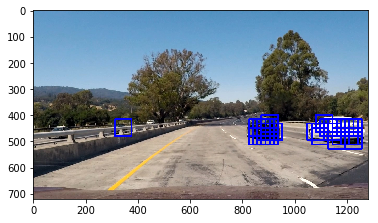

In [92]:
y_start_stop = [400, 656]  # Min and max in y to search in slide_window()
x_start_stop = [200, None] # Min and max in x to search in slide_window()
scale = 1
    
img = mpimg.imread('test_images/test1.jpg')
out_img, bbox_list = find_cars(img, x_start_stop, y_start_stop, scale, 
                               clf, X_scaler, 
                               color_space, spatial_size, hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)   

plt.imshow(out_img)

### Multiple Detections & False Positives

In [98]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    bbox_color = [(255,0,0), (0,0,255), (0,255,0)]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], bbox_color[car_number%3], 6)
    # Return the image
    return img

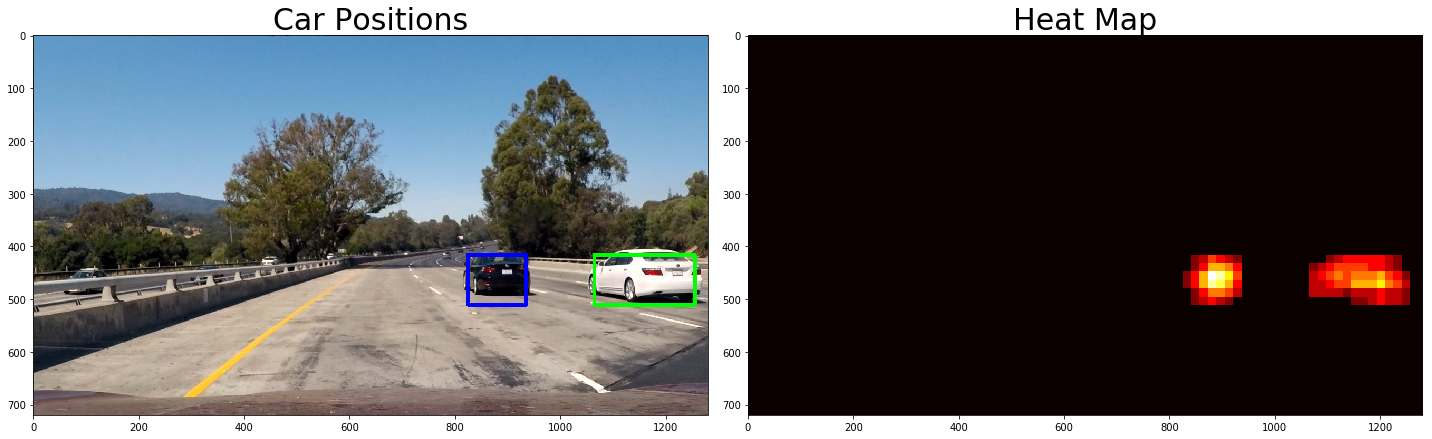

In [99]:
y_start_stop = [400, 656]  # Min and max in y to search in slide_window()
x_start_stop = [200, None] # Min and max in x to search in slide_window()
scale = 1
    
img = mpimg.imread('test_images/test1.jpg')
out_img, bbox_list = find_cars(img, x_start_stop, y_start_stop, scale, 
                               clf, X_scaler, 
                               color_space, spatial_size, hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat) 

heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=30)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=30)
fig.tight_layout()

In [120]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from collections import deque

from scipy.ndimage.measurements import label
    

class Vehicle(object):
    
    def __init__(self):
        self.y_start_stop = [400, 656]  # Min and max in y to search in slide_window()
        self.x_start_stop = [200, None] # Min and max in x to search in slide_window()
        self.scale = 1
        self.bbox_list = deque(maxlen=3)
        self.heat_threshold = 1
        
        
    def loadModel(self, pFile="classifier.p"):
        """ Load classifier from pickle file """
        
        dist_pickle = pickle.load( open(pFile, "rb" ) )
        self.clf = dist_pickle["clf"]
        self.X_scaler = dist_pickle["scaler"]
        self.color_space = dist_pickle["color_space"]
        self.spatial_size = dist_pickle["spatial_size"]
        self.hist_bins = dist_pickle["hist_bins"]
        self.orient = dist_pickle["orient"]
        self.pix_per_cell = dist_pickle["pix_per_cell"]
        self.cell_per_block = dist_pickle["cell_per_block"]
        self.hog_channel = dist_pickle["hog_channel"]
        self.spatial_feat = dist_pickle["spatial_feat"]
        self.hist_feat = dist_pickle["hist_feat"]
        self.hog_feat = dist_pickle["hog_feat"]
        print("Load model from", pFile)
    
    
    def find_cars(self, img):
        """ Extract features using hog sub-sampling and make predictions """
        
        xstart, xstop = self.x_start_stop
        ystart, ystop = self.y_start_stop

        if xstart == None:
            xstart = 0
        if xstop == None:
            xstop = img.shape[1]
        if ystart == None:
            ystart = 0
        if ystop == None:
            ystop = img.shape[0]

        draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,xstart:xstop,:]

        # apply color conversion if other than 'RGB'
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif self.color_space == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif self.color_space == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif self.color_space == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif self.color_space == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        else: 
            ctrans_tosearch = np.copy(img_tosearch) 

        if self.scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
        nfeat_per_block = self.orient*self.cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            if self.hog_channel == 'ALL':
                for channel in range(ctrans_tosearch.shape[2]):
                    hog_features.append(get_hog_features(ctrans_tosearch[:,:,channel], 
                                        self.orient, self.pix_per_cell, self.cell_per_block, 
                                        vis=False, feature_vec=False))
            else:
                hog_features.append(get_hog_features(ctrans_tosearch[:,:,self.hog_channel], self.orient, 
                            self.pix_per_cell, self.cell_per_block, vis=False, feature_vec=False))

        bbox_list = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # Extract features for this patch
                patch_features = []

                # Extract the image patch
                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # cv2.rectangle(draw_img,(xleft, ytop+ystart),(xleft+window,ytop+window+ystart),(0,0,255),6) 

                # Get color features
                if self.spatial_feat == True:
                    spatial_features = bin_spatial(subimg, size=self.spatial_size)
                    patch_features.append(spatial_features)
                if self.hist_feat == True:
                    # Apply color_hist()
                    hist_features = color_hist(subimg, nbins=self.hist_bins)
                    patch_features.append(hist_features)

                # Get HOG features
                if self.hog_feat == True:
                    hot_patch_features = None
                    for ii in range(len(hog_features)):
                        hog_ch = hog_features[ii]
                        hog_ch_feat = hog_ch[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                        if hot_patch_features == None:
                            hot_patch_features = hog_ch_feat
                        else:
                            hot_patch_features = np.hstack((hot_patch_features, hog_ch_feat))
                    patch_features.append(hot_patch_features)

                # scale features and make a prediction
                test_features = self.X_scaler.transform(np.hstack(patch_features).reshape(1, -1))    
                test_prediction = self.clf.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*self.scale)
                    ytop_draw = np.int(ytop*self.scale)
                    win_draw = np.int(window*self.scale)
                    bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 

        return draw_img, bbox_list
    
    
    def add_heat(self, heatmap):
        # Iterate through list of bboxes
        for box_list in self.bbox_list:
            for box in box_list:
                # Add += 1 for all pixels inside each bbox
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap

    
    def apply_threshold(self, heatmap):
        # Zero out pixels below the threshold
        heatmap[heatmap <= self.heat_threshold] = 0
        # Return thresholded map
        return heatmap

    
    def draw_labeled_bboxes(self, img, labels):
        draw_img = np.copy(img)
        
        bbox_color = [(255,0,0), (0,0,255), (0,255,0)]
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(draw_img, bbox[0], bbox[1], bbox_color[car_number%3], 6)
        # Return the image
        return draw_img

    
    def pipeline(self, img):
        out_img, bbox_list = self.find_cars(img)
        
        # Update bounding box
        self.bbox_list.append(bbox_list)
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = self.add_heat(heat)

        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(img, labels)
        
        return draw_img
    
    
    def setThreshold(self, threshold):
        self.heat_threshold = threshold
    
    
vehicle = Vehicle()
vehicle.loadModel('classifier.p')

Load model from classifier.p


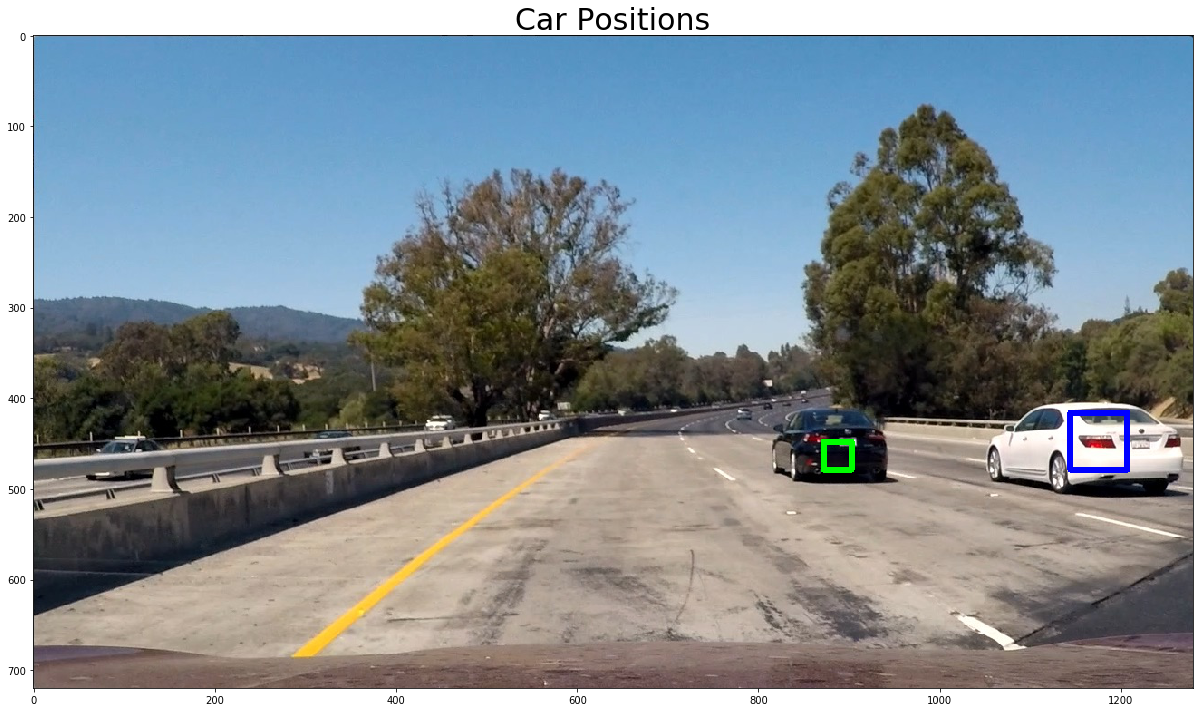

In [123]:
vehicle.setThreshold(10)

img = mpimg.imread('test_images/test1.jpg')
draw_img = vehicle.pipeline(img)

fig = plt.figure(figsize=(20,10))
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=30)
fig.tight_layout()

## Video Pipeline

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

def video_pipeline(intput_file, output_file):
    project_video_output = output_file
    clip1 = VideoFileClip(intput_file)
#     clip1 = VideoFileClip(intput_file).subclip(0,5)
    project_video_clip = clip1.fl_image(vehicle.pipeline)
    %time project_video_clip.write_videofile(project_video_output, audio=False)
    
video_pipeline("project_video.mp4", "output_images/project_video.mp4")

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4



  2%|▏         | 20/1261 [00:18<14:02,  1.47it/s]